 Id - an Id that represents a (Store, Date) duple within the test set
Store- a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import bs4

In [4]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Handle table like data and matrices
import numpy as np
import pandas as pd
import math

# Modelling Algorithm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Modelling Helpers
#from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Visualization Configuration
%matplotlib inline
mpl.style.use("ggplot")
sns.set_style("white")
plt.rcParams["figure.figsize"] = 12, 8

In [5]:
# Read the file
df = pd.read_csv("../Data/train.csv")
store = pd.read_csv("../Data/store.csv")
test = pd.read_csv("../Data/test.csv")

# check the first 5 rows
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


<AxesSubplot:xlabel='Promo', ylabel='Sales'>

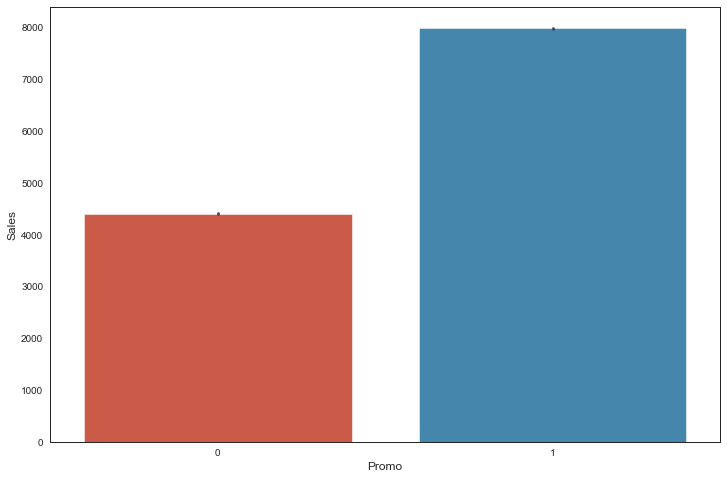

In [6]:
sns.barplot(x='Promo', y='Sales', data=df)

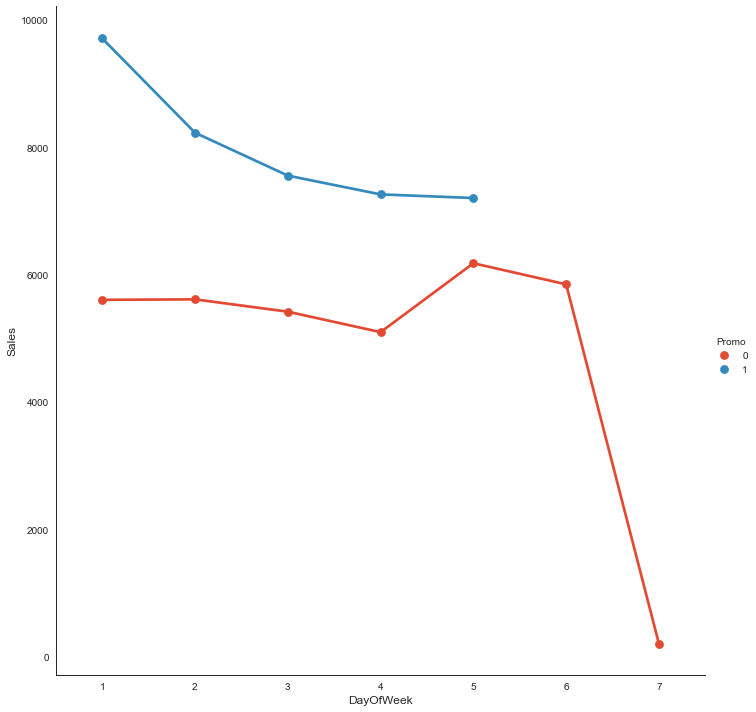

In [7]:
sns.factorplot(x='DayOfWeek', y='Sales', data=df, hue='Promo', size=10)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

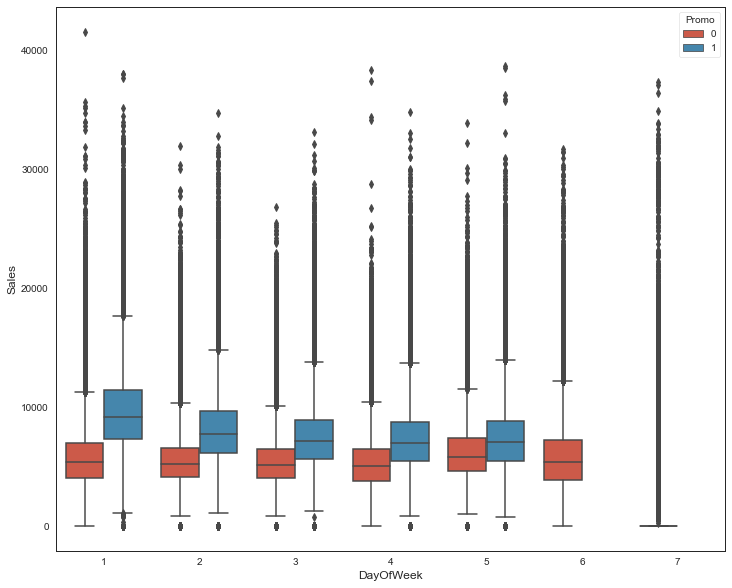

In [8]:
plt.rcParams['figure.figsize'] = (12,10)
sns.boxplot(x='DayOfWeek', y='Sales', data=df, hue='Promo')

Based on the visuals above, the first thing that jumps out here is the company dosen't run any promotiions on the weekends and in terms of comparison promotion has huge effect on sales on monday and very lesss on friday

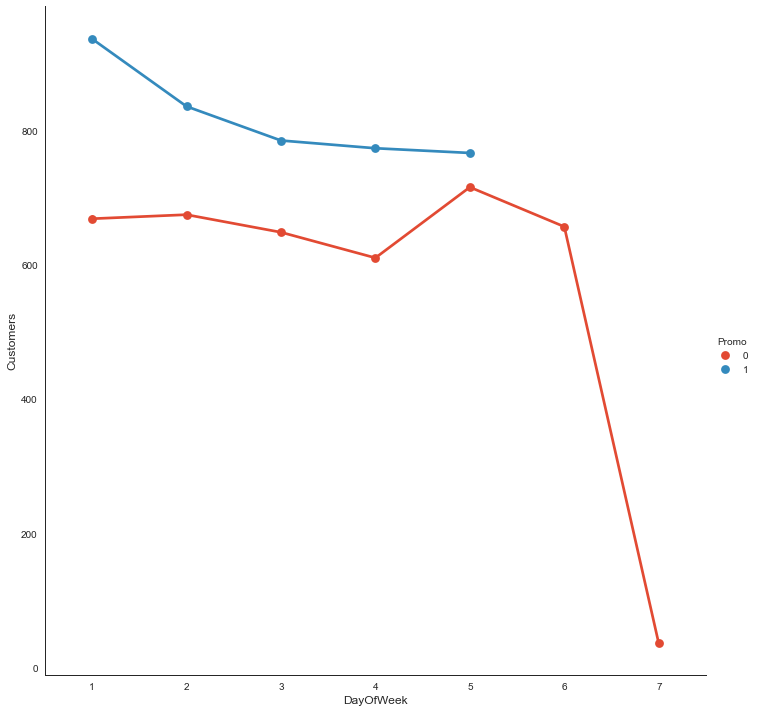

In [9]:
sns.factorplot(x='DayOfWeek', y='Customers', hue='Promo', data=df, size=10)

In [10]:
df.Date.unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

In [11]:
# check the unique data in the following column
cols = ["DayOfWeek", "SchoolHoliday", "StateHoliday", "Open", "Promo"]

for col in cols:
    print(col)
    print(df[col].unique())
    print("-------")

DayOfWeek
[5 4 3 2 1 7 6]
-------
SchoolHoliday
[1 0]
-------
StateHoliday
['0' 'a' 'b' 'c' 0]
-------
Open
[1 0]
-------
Promo
[1 0]
-------


In [12]:
# check the no of stores in the data
df['Store'].nunique()

1115

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [14]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Visualization

<AxesSubplot:xlabel='Open'>

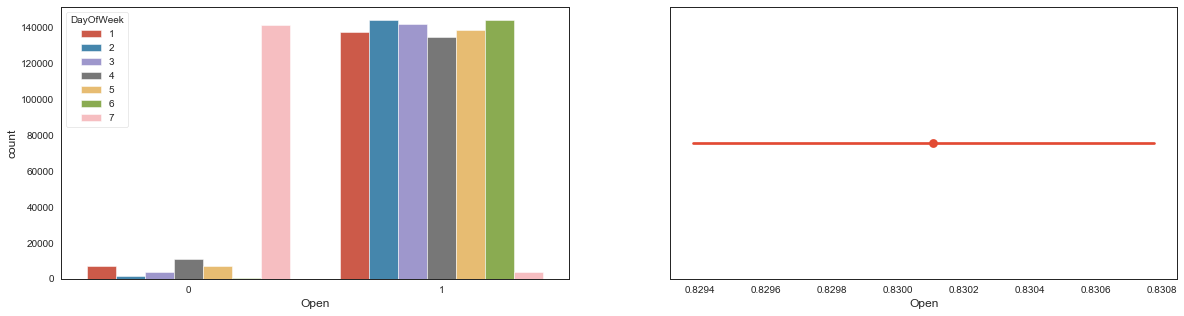

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(ax=ax1, data=df, hue='DayOfWeek', x='Open')
sns.pointplot(ax=ax2, data=df, hue='DayOfWeek', x='Open')

** The chart shows the stores are mainly closed on Sunday

In [16]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
# Extract the year, month and day from the date column

df['Year'] = df.Date.apply(lambda x: x.split("-"))
df['Month'] = df.Year.apply(lambda x: int(x[1]))
df['Day'] = df.Year.apply(lambda x: int(x[2]))
df['Year'] = df.Year.apply(lambda x: int(x[0]))

avgSales = df.groupby('Date')['Sales'].mean()
percentageSale = df.groupby('Date')['Sales'].sum().pct_change()

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31


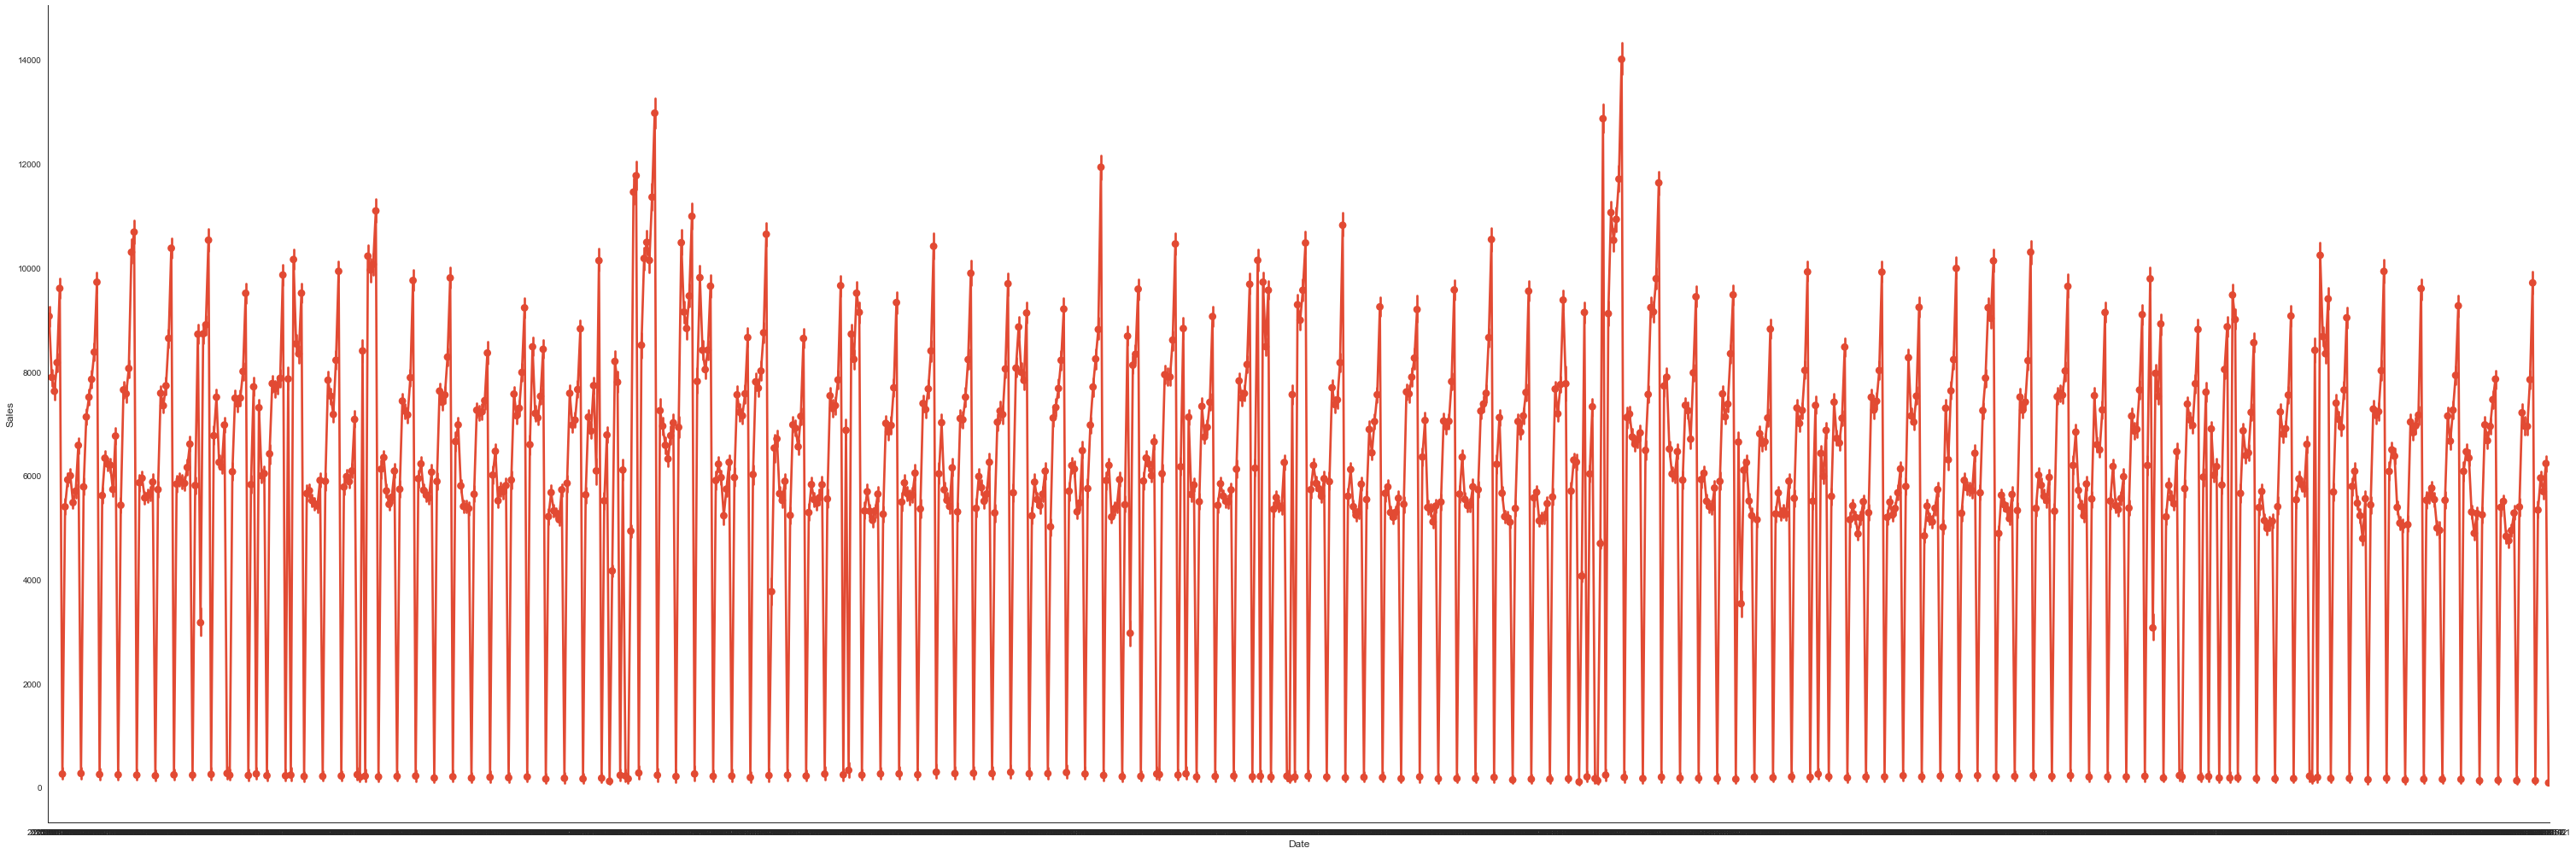

In [18]:
plt.rcParams['figure.figsize'] = 20,5
sns.factorplot(x="Date", y="Sales", data=df, aspect=3, size=14, kind="point")

<AxesSubplot:>

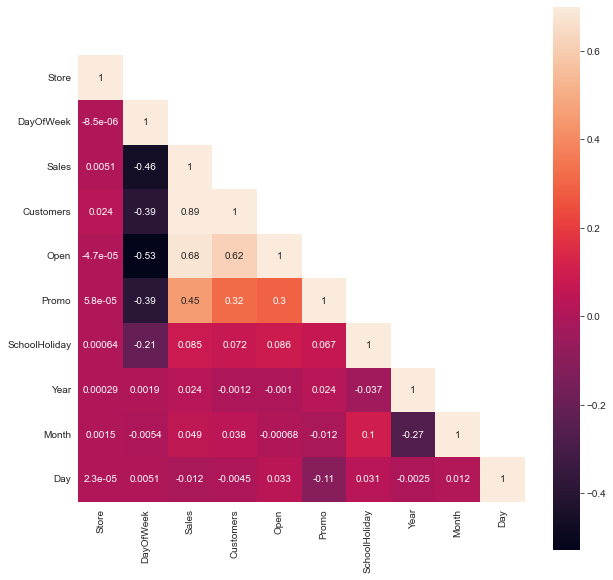

In [19]:
# HeatMap to show correlation between numerical colunms

corr_map = df[df.columns].corr()
obj = np.array(corr_map)
obj[np.tril_indices_from(obj)] = False
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corr_map, mask=obj, square=True, annot=True, vmax=.7)

In [20]:
def plotter(stringA, stringB):
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(15,8)
    sns.barplot(x=stringA, y=stringB, data=df, hue='DayOfWeek', ax=ax[0])
    sns.boxplot(x=stringA, y=stringB, data=df, hue='DayOfWeek', ax=ax[1])

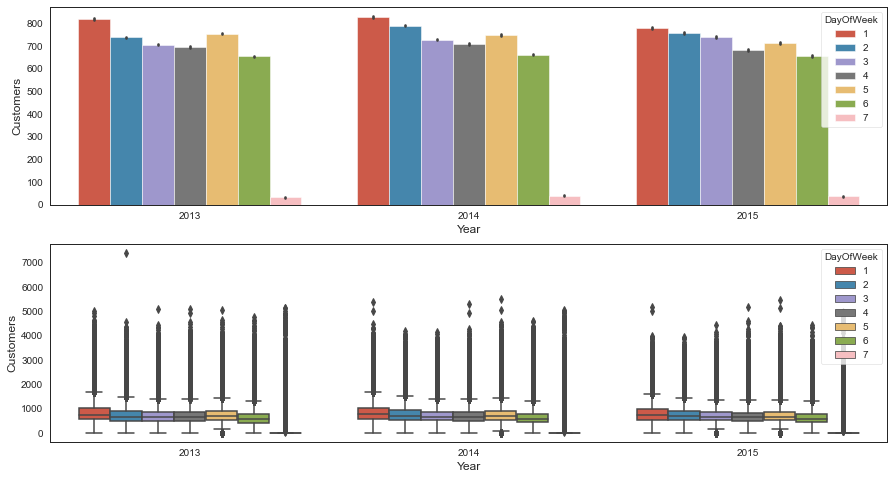

In [21]:
plotter("Year", "Customers")

In [22]:
# Encode StateHoliday
df['StateHoliday'] = df['StateHoliday'].map({0:0, "0":0, "a":1, "b":1, "c":1})
df['StateHoliday'].value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

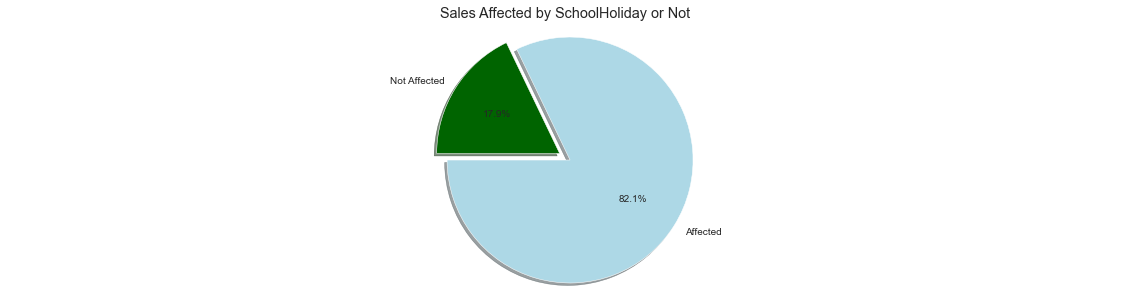

In [23]:
labels = "Affected", "Not Affected"
sizes = df.SchoolHoliday.value_counts()
colors = ["lightblue", "darkgreen"]
explode = (0.1,0.0)
plt.pie(sizes, explode=explode, colors=colors, labels=labels, autopct="%1.1f%%", shadow=True, startangle=180)
plt.axis("equal")
plt.title("Sales Affected by SchoolHoliday or Not")
plt.plot()
fig.set_size_inches(8,8)

<AxesSubplot:ylabel='Frequency'>

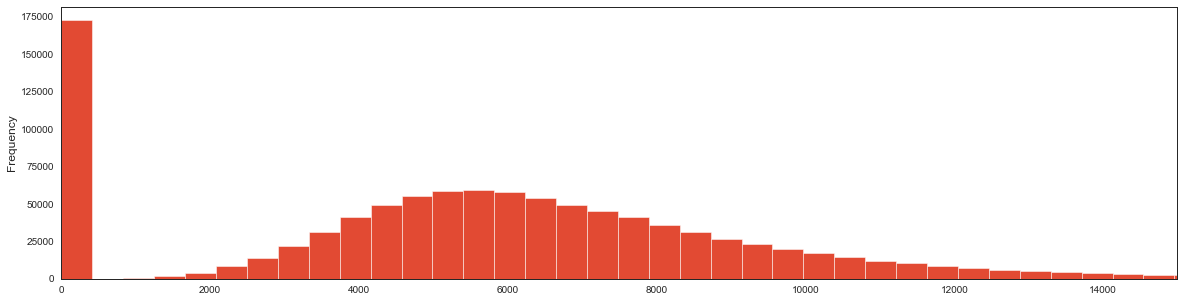

In [24]:
df.Sales.plot(kind='hist', bins=100, xlim=(0,15000))

In [25]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [26]:
temp = []
for i in df.groupby('Store')[['Sales', 'Customers']].mean()['Sales']:
    temp.append(i)
store['Sales'] = temp

In [27]:
temp = []
for i in df.groupby('Store')[['Sales', 'Customers']].mean()['Customers']:
    temp.append(i)
store['Customers'] = temp

In [28]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3945.704883,467.646497
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",4122.991507,486.045648
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",5741.253715,620.286624
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,8021.769639,1100.057325
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,3867.110403,444.360934


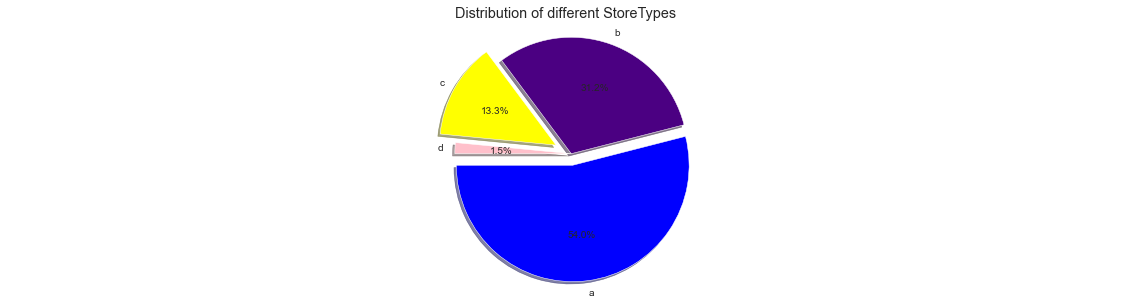

In [29]:
labels = "a", "b", "c", "d"
sizes = store.StoreType.value_counts()
colors = ["blue", "indigo", "yellow", "pink"]
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=explode, shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.gcf()
plt.plot()
fig.set_size_inches = (10,10)

In [30]:
def plotmaster(StringA , StringB):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(12, 15)
  sns.barplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax=axes[1])
  sns.violinplot(x=StringA, y=StringB, data=store, hue="StoreType" , ax=axes[2])

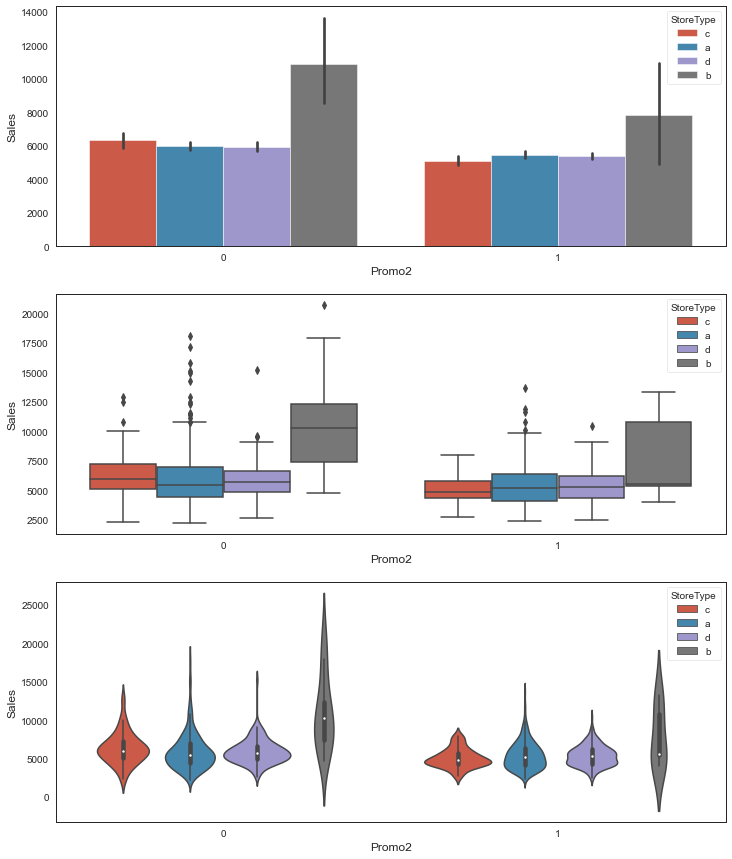

In [31]:
plotmaster("Promo2", "Sales")

In [33]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
Sales                          0
Customers                      0
dtype: int64

In [34]:
# To get Stores Which are open on Sunday
df[(df['Open'] == 1) & (df['DayOfWeek'] == 7)]['Store'].unique()


array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877],
      dtype=int64)

Building The Model

In [35]:
df = df[df["Open"] != 0] # Selecting rows at which store was open
df = df[df["Sales"] > 0] # selecting rows where sales where made
df['log_sales'] = np.log(df['Sales']) # get the log sales to remove skewness (Normalizing) 
df = pd.merge(df, store, on='Store') # Merge storeInfo with the train dataset
df.fillna(0,inplace=True) # replace all missing values with 0


In [36]:
df = pd.get_dummies(df,columns=['StoreType','Assortment','Year'])

In [37]:
X = df.drop(['Sales_x','Sales_y','log_sales','Store','Date','Customers_x','Customers_y','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)
y = df['log_sales']

In [38]:
X = X.drop('Day', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=28)

In [39]:
%%time
from sklearn import linear_model
from sklearn import metrics
reg = linear_model.LinearRegression()
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred, y_val)))

RMSE:  0.37251323148605814
CPU times: total: 1.36 s
Wall time: 1.03 s


In [40]:
%%time
tree = DecisionTreeRegressor(max_depth=50,min_samples_split=8)
tree = tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_pred_tree, y_val)))

RMSE:  0.1583834884907666
CPU times: total: 8.17 s
Wall time: 8.23 s


In [41]:
print("MSE: ", metrics.mean_squared_error(y_pred_tree, y_val))

MSE:  0.025085329426504804


Implement Neural Network with BackPropagation using A Multi-layer Perceptron

In [42]:
%%time
neural_net = MLPRegressor(early_stopping=True,activation='tanh',hidden_layer_sizes=(10,),verbose=True,solver='adam')
neural_net = neural_net.fit(X_train, y_train)
neural_pred = neural_net.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(neural_pred, y_val)))

Iteration 1, loss = 3.78151384
Validation score: 0.000698
Iteration 2, loss = 0.09016355
Validation score: 0.002771
Iteration 3, loss = 0.09005002
Validation score: 0.003703
Iteration 4, loss = 0.09005277
Validation score: 0.002950
Iteration 5, loss = 0.09005837
Validation score: 0.000524
Iteration 6, loss = 0.09016518
Validation score: 0.004055
Iteration 7, loss = 0.09004124
Validation score: 0.000839
Iteration 8, loss = 0.09000557
Validation score: 0.004110
Iteration 9, loss = 0.09000898
Validation score: 0.004236
Iteration 10, loss = 0.08998285
Validation score: 0.003481
Iteration 11, loss = 0.09024039
Validation score: 0.004555
Iteration 12, loss = 0.08998135
Validation score: 0.003010
Iteration 13, loss = 0.08996838
Validation score: 0.002643
Iteration 14, loss = 0.09005388
Validation score: 0.002638
Iteration 15, loss = 0.08997630
Validation score: 0.004100
Iteration 16, loss = 0.08998573
Validation score: 0.000509
Iteration 17, loss = 0.08996931
Validation score: 0.004353
Iterat

In [43]:
X_train.columns

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Month',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'Year_2013', 'Year_2014', 'Year_2015'],
      dtype='object')

Neural Network is known to performed even better with a normalized data i.e data with close scale StandardScaler() can help do that. it will change the data so that it has a mean of 0 and variance of 1

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [45]:
%%time
neural_net = neural_net.fit(X_train, y_train)
neural_pred = neural_net.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(neural_pred, y_val)))

Iteration 1, loss = 4.52488832
Validation score: -2.065119
Iteration 2, loss = 0.19766219
Validation score: -0.545031
Iteration 3, loss = 0.12585369
Validation score: -0.049716
Iteration 4, loss = 0.08448340
Validation score: 0.208334
Iteration 5, loss = 0.06923425
Validation score: 0.265199
Iteration 6, loss = 0.06578565
Validation score: 0.279117
Iteration 7, loss = 0.06449860
Validation score: 0.288002
Iteration 8, loss = 0.06388370
Validation score: 0.292897
Iteration 9, loss = 0.06348320
Validation score: 0.298352
Iteration 10, loss = 0.06317031
Validation score: 0.294943
Iteration 11, loss = 0.06282394
Validation score: 0.300477
Iteration 12, loss = 0.06245954
Validation score: 0.306843
Iteration 13, loss = 0.06211367
Validation score: 0.307825
Iteration 14, loss = 0.06188361
Validation score: 0.311200
Iteration 15, loss = 0.06176136
Validation score: 0.313519
Iteration 16, loss = 0.06163511
Validation score: 0.313664
Iteration 17, loss = 0.06155600
Validation score: 0.312289
Ite